In [9]:
import glob
import os
import random
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class SubgridMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list, output_dim: int, dropout: float = 0.1):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers += [
                nn.Linear(prev, h), nn.ReLU(inplace=True),
                nn.BatchNorm1d(h), nn.Dropout(dropout)
            ]
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class ChunkedLatLonDataset(Dataset):
    """
    Load global (time, lev, face, y, x), reshape to (time, lev, face*y, x),
    then chunk into (lev, chunk_fy, chunk_x). Spatial coords as extra features.
    No data normalization applied.
    """
    def __init__(self, file_pattern: str, in_var: str, tgt_var: str,
                 chunk_fy: int = 30, chunk_x: int = 15):
        files = glob.glob(file_pattern)
        print(f"Found {len(files)} files to load.")
        ds = xr.open_mfdataset(files, combine='by_coords')
        arr_in = ds[in_var].values.astype('float32')   # raw (t, lev, face, y, x)
        arr_tgt = ds[tgt_var].values.astype('float32') # raw

        t, lev, face, ny, nx = arr_in.shape
        self.lev = lev
        # reshape face & y dims to single axis
        fy = face * ny
        arr_in = arr_in.reshape(t, lev, fy, nx)
        arr_tgt = arr_tgt.reshape(t, lev, fy, nx)

        # create spatial coordinate maps (normalized)
        fy_idx = np.arange(fy, dtype='float32') / (fy - 1)
        x_idx  = np.arange(nx, dtype='float32') / (nx - 1)
        coord_fy, coord_x = np.meshgrid(fy_idx, x_idx, indexing='ij')  # (fy, nx)

        self.chunks = []
        # chunk each sample
        for ti in range(t):
            for yi in range(0, fy, chunk_fy):
                for xi in range(0, nx, chunk_x):
                    sub_in  = arr_in[ti, :, yi:yi+chunk_fy, xi:xi+chunk_x]
                    sub_tgt = arr_tgt[ti, :, yi:yi+chunk_fy, xi:xi+chunk_x]
                    cf = coord_fy[yi:yi+chunk_fy, xi:xi+chunk_x]
                    cx = coord_x[ yi:yi+chunk_fy, xi:xi+chunk_x]
                    data = sub_in.reshape(-1)
                    coords = np.stack([
                        np.repeat(cf, lev),
                        np.repeat(cx, lev)
                    ], axis=0).transpose(1,0).reshape(-1)
                    target = sub_tgt.reshape(-1)
                    self.chunks.append((np.concatenate([data, coords]), target))

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx: int):
        inp, tgt = self.chunks[idx]
        return torch.from_numpy(inp), torch.from_numpy(tgt)

if __name__ == '__main__':
    random.seed(0)
    # define chunk sizes
    chunk_fy, chunk_x = 30, 15
    dataset = ChunkedLatLonDataset(
        "/home/afahad/nb/subgrid_tend/6km/Ttrain_*.nc4",
        'dT', 'subT', chunk_fy=chunk_fy, chunk_x=chunk_x
    )
    total = len(dataset)
    print(f"Total chunks: {total}")

    # split into train/val/test
    idxs = list(range(total)); random.shuffle(idxs)
    t1, t2 = int(0.7*total), int(0.85*total)
    train_set = Subset(dataset, idxs[:t1])
    val_set   = Subset(dataset, idxs[t1:t2])
    test_set  = Subset(dataset, idxs[t2:])

    batch_size = 16
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size)

    lev = dataset.lev
    mult = chunk_fy * chunk_x
    feat_per_chunk = lev * mult * 3  # data + 2 coord channels
    out_dim = lev * mult

    model = SubgridMLP(feat_per_chunk, [512, 256], out_dim, dropout=0.3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    mse_fn = nn.MSELoss()
    checkpoint = 'chunk_model_no_norm.pth'
    best_val = float('inf')
    if os.path.exists(checkpoint):
        model.load_state_dict(torch.load(checkpoint, map_location=device))
        print(f"Resumed from checkpoint {checkpoint}.")

    # training loop
    epochs = 20
    for ep in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            yp = model(xb)
            loss = mse_fn(yp, yb)*1e10  # raw MSE on unnormalized data
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train = np.mean(train_losses)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_losses.append(mse_fn(model(xb), yb).item()*1e10)
        avg_val = np.mean(val_losses)
        print(f"Epoch {ep}: train_mse={avg_train:.6f}, val_mse={avg_val:.6f}")

        if avg_val < best_val:
            best_val = avg_val
            torch.save(model.state_dict(), checkpoint)

    # test and plot one chunk sample
    model.load_state_dict(torch.load(checkpoint, map_location=device)); model.eval()
    xb, yb = test_set[0]
    with torch.no_grad(): yp = model(xb.unsqueeze(0).to(device)).squeeze(0).cpu().numpy()
    y_true = yb.numpy()   # raw target
    y_pred = yp            # raw prediction
    t_arr = y_true.reshape(lev, chunk_fy, chunk_x)
    p_arr = y_pred.reshape(lev, chunk_fy, chunk_x)
    slice_true, slice_pred = t_arr[0], p_arr[0]
    vmin, vmax = slice_true.min(), slice_true.max()
    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1); plt.title('True'); plt.imshow(slice_true, origin='lower', vmin=vmin, vmax=vmax); plt.colorbar()
    plt.subplot(1,2,2); plt.title('Pred'); plt.imshow(slice_pred, origin='lower', vmin=vmin, vmax=vmax); plt.colorbar(); plt.show()

Using device: cuda
Found 985 files to load.
Total chunks: 106380
Resumed from checkpoint chunk_model_no_norm.pth.


Epoch 1: train_mse=2759.914809, val_mse=33.605794


Epoch 2: train_mse=23.181971, val_mse=20.124749


Epoch 3: train_mse=20.378417, val_mse=20.513845


Epoch 4: train_mse=179.413095, val_mse=8.509982


Epoch 5: train_mse=16.765443, val_mse=20.572792


Epoch 6: train_mse=274.481893, val_mse=120.310651


Epoch 7: train_mse=12.156267, val_mse=605738331.455703


Epoch 8: train_mse=192.189951, val_mse=73713003270.850266


Epoch 9: train_mse=16.797738, val_mse=2128791341.608830


Epoch 10: train_mse=183.507845, val_mse=15863473178.976841


Epoch 11: train_mse=16.689256, val_mse=196860544852.700470


Epoch 12: train_mse=148.687354, val_mse=30928700918.133327


Epoch 13: train_mse=16.419653, val_mse=142229846004.467651


KeyboardInterrupt: 

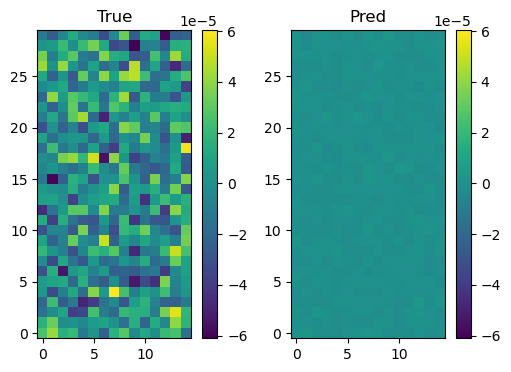

In [7]:
    # test and plot one chunk sample
    model.load_state_dict(torch.load(checkpoint, map_location=device)); model.eval()
    xb, yb = test_set[0]
    with torch.no_grad(): yp = model(xb.unsqueeze(0).to(device)).squeeze(0).cpu().numpy()
    y_true = yb.numpy() * (dataset.tgt_max - dataset.tgt_min) + dataset.tgt_min
    y_pred = yp * (dataset.tgt_max - dataset.tgt_min) + dataset.tgt_min
    t_arr = y_true.reshape(lev, chunk_fy, chunk_x)
    p_arr = y_pred.reshape(lev, chunk_fy, chunk_x)
    slice_true, slice_pred = t_arr[0], p_arr[0]
    vmin, vmax = slice_true.min(), slice_true.max()
    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1); plt.title('True'); plt.imshow(slice_true, origin='lower', vmin=vmin, vmax=vmax); plt.colorbar()
    plt.subplot(1,2,2); plt.title('Pred'); plt.imshow(slice_pred, origin='lower', vmin=vmin, vmax=vmax); plt.colorbar(); plt.show()


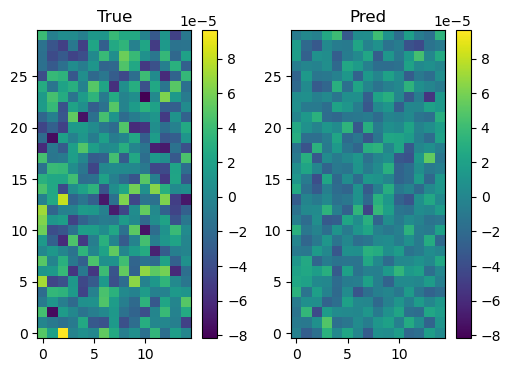

In [12]:
    # test and plot one chunk sample
    model.load_state_dict(torch.load(checkpoint, map_location=device)); model.eval()
    xb, yb = test_set[0]
    with torch.no_grad(): yp = model(xb.unsqueeze(0).to(device)).squeeze(0).cpu().numpy()
    y_true = yb.numpy()   # raw target
    y_pred = yp            # raw prediction
    t_arr = y_true.reshape(lev, chunk_fy, chunk_x)
    p_arr = y_pred.reshape(lev, chunk_fy, chunk_x)
    slice_true, slice_pred = t_arr[-1], p_arr[-1]
    vmin, vmax = slice_true.min(), slice_true.max()
    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1); plt.title('True'); plt.imshow(slice_true, origin='lower', vmin=vmin, vmax=vmax); plt.colorbar()
    plt.subplot(1,2,2); plt.title('Pred'); plt.imshow(slice_pred, origin='lower', vmin=vmin, vmax=vmax); plt.colorbar(); plt.show()